# LAI experiment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import tgess
import os
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from tqdm.auto import tqdm
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, \
                            r2_score, mean_absolute_percentage_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, RationalQuadratic
from modAL.models import ActiveLearner

from tgess.src.data_science.plots import *
from tgess.src.data_science.experiment import *

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
sns.set_style("whitegrid")

tqdm.pandas()


/home/vneuteboom/anaconda3/envs/master-thesis/lib/python3.7/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


## Load data

In [3]:
def map_to_degrees(x):
    if x<0:
        x = 360+x
    else:
        x = x
    return x

In [3]:
def load_LAI_data(in_situ_path="../data/processed/", in_situ_file="GBOV_LAI_final.csv", \
                  simulation_path="../data/processed/", simulation_file="PROSAIL_LUT_S2_100000_generic.csv"):
    

    rename_cols = {"zenith_angle":"solar_zenith", 
                   "azimuth_angle":"solar_azimuth",
                   "mean_incidence_azimuth":"observer_azimuth",
                   "mean_incidence_zenith":"observer_zenith"
                  }
    
    in_situ_df = pd.read_csv(os.path.join(in_situ_path, in_situ_file)).iloc[:, 1:] # Drop first column
    in_situ_df = in_situ_df.rename(columns = rename_cols)
        
    in_situ_df["relative_azimuth"] = (in_situ_df["solar_azimuth"] - in_situ_df["observer_azimuth"])\
                                            .apply(map_to_degrees)
    
    in_situ_df = in_situ_df.dropna()
    
    
    rename_cols = {"tts":"solar_zenith", 
                   "tto":"observer_zenith",
                   "psi":"relative_azimuth"
                  }
    
    simulation_df = pd.read_csv(os.path.join(simulation_path, simulation_file)).iloc[:, 1:] # Drop first column
    simulation_df = simulation_df.rename(columns = rename_cols)
    simulation_df = simulation_df.dropna()
    return in_situ_df, simulation_df

In [4]:
in_situ_df, simulation_df = load_LAI_data()

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/GBOV_LAI_final.csv'

In [5]:
in_situ_df = pd.read_csv("../data/processed/GBOV_RM07_in_situ.csv")

In [6]:
simulation_df = pd.read_csv("../data/processed/PROSAIL_LUT_S2_100000_generic.csv")

## Debugging, data inspection

In [7]:
in_situ_df.columns

Index(['Unnamed: 0', 'Site', 'date', 'plotID', 'retrieval_date', 'LAI_Miller',
       'LAI_Warren', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A',
       'B9', 'B10', 'B11', 'B12', 'QA10', 'QA20', 'QA60', 'cloud_probability',
       'nlcdClass', 'observer_azimuth', 'observer_zenith', 'solar_zenith',
       'solar_azimuth', 'relative_azimuth'],
      dtype='object')

In [8]:
in_situ_df["nlcdClass"].unique()

array(['deciduousForest', 'cultivatedCrops', 'evergreenForest',
       'mixedForest', 'shrubScrub', 'pastureHay', 'grasslandHerbaceous',
       'woodyWetlands', 'emergentHerbaceousWetlands'], dtype=object)

In [7]:
simulation_df.columns

Index(['Unnamed: 0', 'n', 'cab', 'car', 'cbrown', 'cw', 'cm', 'lai', 'lidfa',
       'hspot', 'solar_zenith', 'observer_zenith', 'relative_azimuth', 'rsoil',
       'psoil', 'typelidf', 'alpha', 'ant', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6',
       'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12'],
      dtype='object')

In [8]:
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']

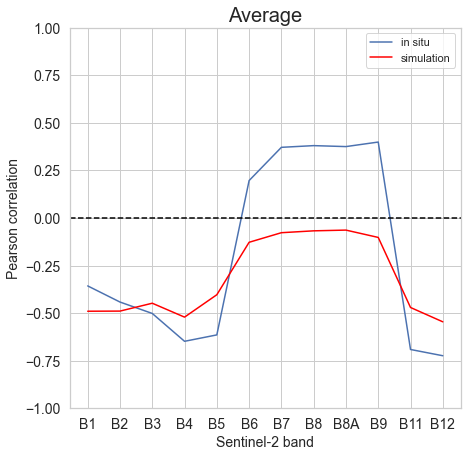

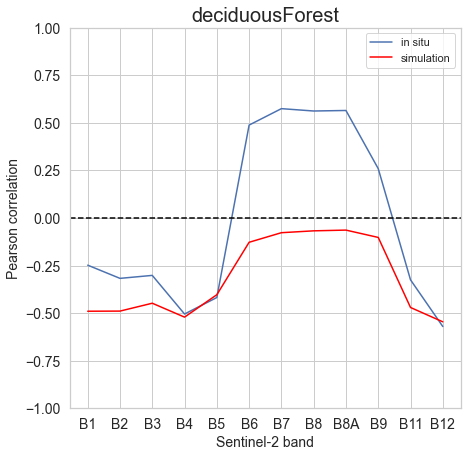

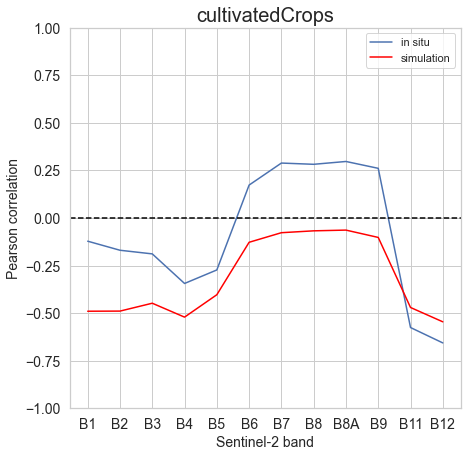

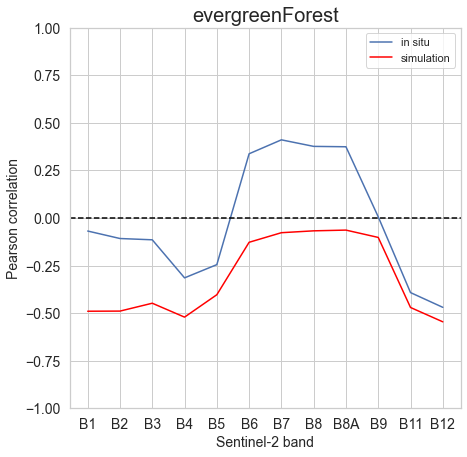

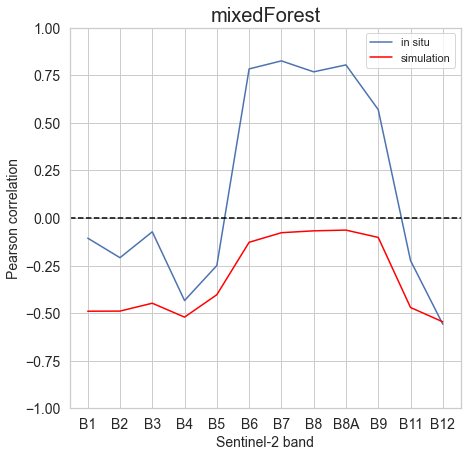

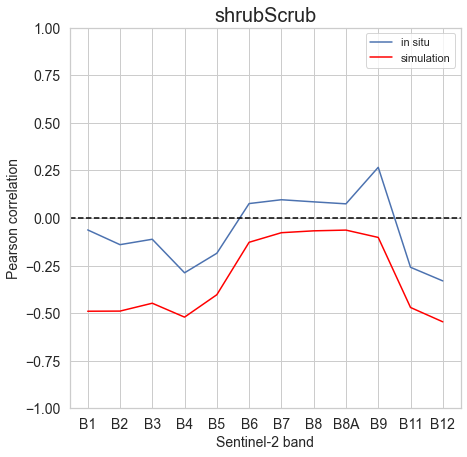

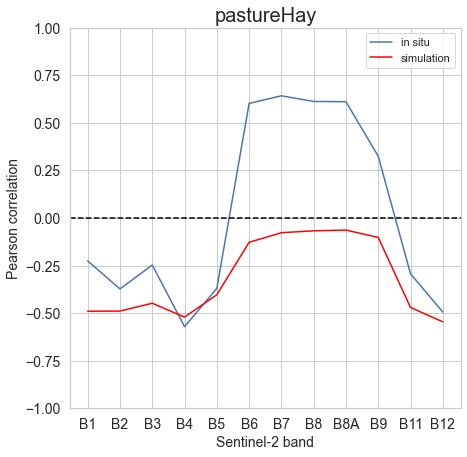

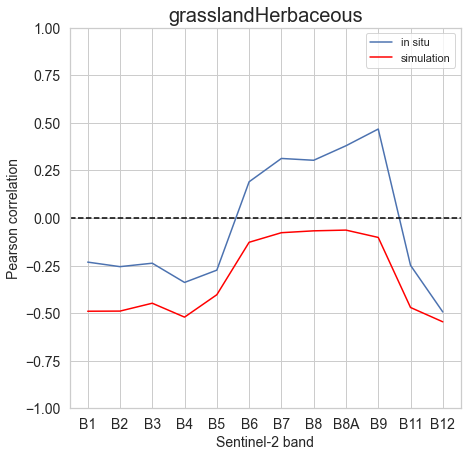

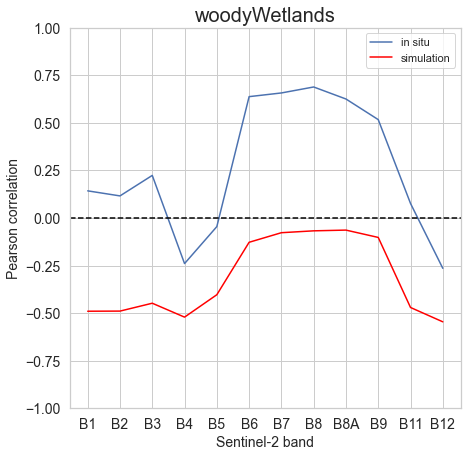

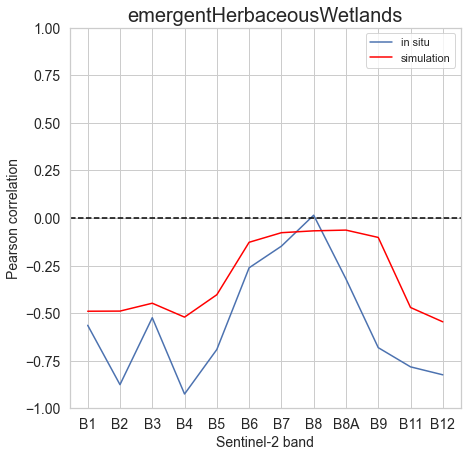

In [69]:
plot_simulation_in_situ_correlation(in_situ_df, simulation_df, bands, ["LAI_Miller", "lai"], "nlcdClass", "Sentinel-2 band", "Pearson correlation", title="Average")

## Cross-validation

In [12]:
def log_results(df, y_pred, metrics, class_columns=["Site", "nlcd_class"]):
    y_true = df["LAI_Warren"]
    
    # Overall results
    results = {}
    for metric in metrics.keys():
        results[metric] = metrics[metric](y_true, y_pred)
    
    # Results per row
    df = pd.DataFrame({"lai":y_true, "predicted_lai":y_pred})
    df["error"] = df["lai"]-df["predicted_lai"]
    df["abs_error"] = np.abs(df["error"])
    
    return df

In [40]:
metrics = {
    "mean_absolute_error":mean_absolute_error, 
    "mean_squared_error":mean_squared_error, \
    "r2":r2_score, 
    "mean_absolute_percentage_error":mean_absolute_percentage_error
}

temp = log_results(in_situ_df, y_pred, metrics).join(in_situ_df["nlcdClass"])
temp.describe()

NameError: name 'log_results' is not defined

In [ ]:
fig, ax = plt.subplots()

temp['bin'] = pd.cut(temp.lai, np.arange(0, 10.5, 1))

ax = sns.heatmap(pd.pivot_table(temp, values='abs_error', 
                     index=['nlcdClass'], 
                     columns='bin'), cmap="coolwarm")


plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
temp.groupby(["nlcdClass", "bin"])["lai"].count().unstack().plot(kind="bar", log=True, \
                                                                 stacked=False, width=1, ax=ax, \
                                                                fontsize=14)
plt.show()

In [22]:
in_situ_df[["nlcdClass"]]

,nlcdClass
0,deciduousForest
1,cultivatedCrops
2,evergreenForest
3,mixedForest
4,evergreenForest
...,...
2999,grasslandHerbaceous
3000,grasslandHerbaceous
3001,grasslandHerbaceous
3002,grasslandHerbaceous


In [35]:
temp_df = in_situ_df["nlcdClass"].value_counts()
temp_df

shrubScrub                    785
deciduousForest               774
evergreenForest               631
grasslandHerbaceous           270
pastureHay                    259
cultivatedCrops               164
woodyWetlands                  64
mixedForest                    53
emergentHerbaceousWetlands      4
Name: nlcdClass, dtype: int64

In [65]:
from tgess.src.data_science.plots import *

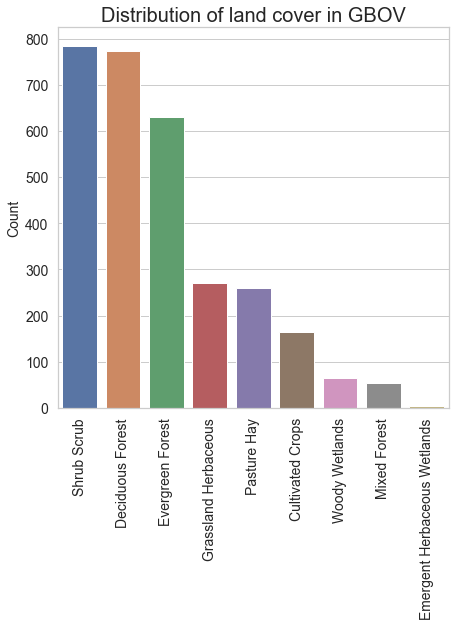

In [70]:
barplot_classes(x=temp_df.index, y=temp_df.values, x_label=None, y_label="Count", title="Distribution of land cover in GBOV")

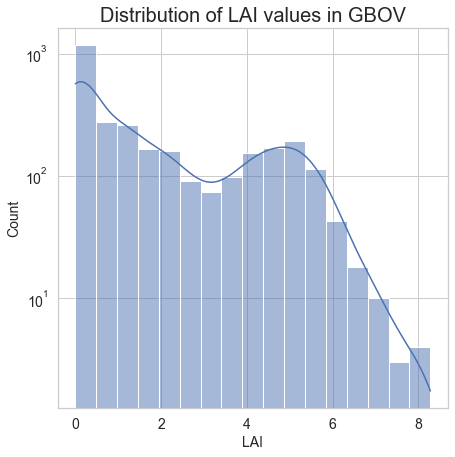

In [11]:
plot_distribution(in_situ_df, "LAI_Warren", "LAI", "Count", "Distribution of LAI values in GBOV")

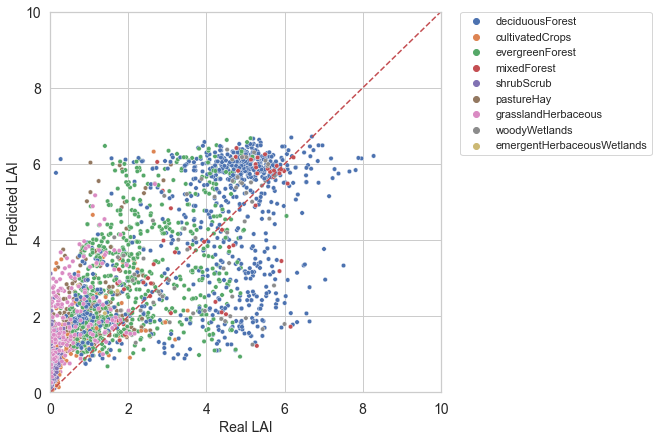

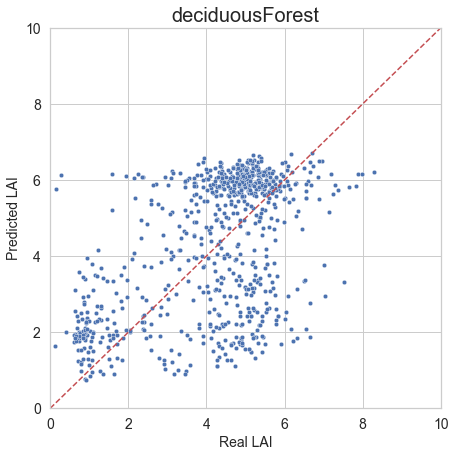

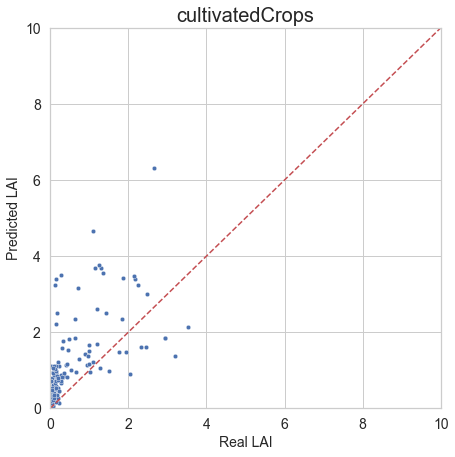

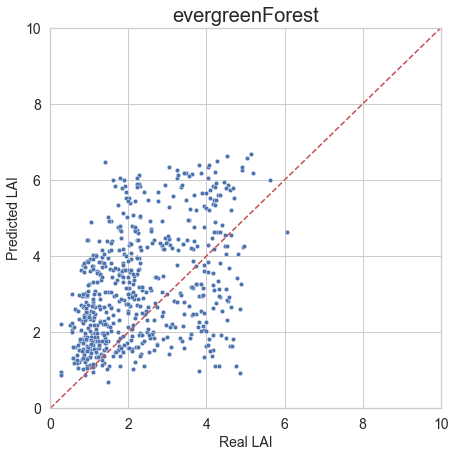

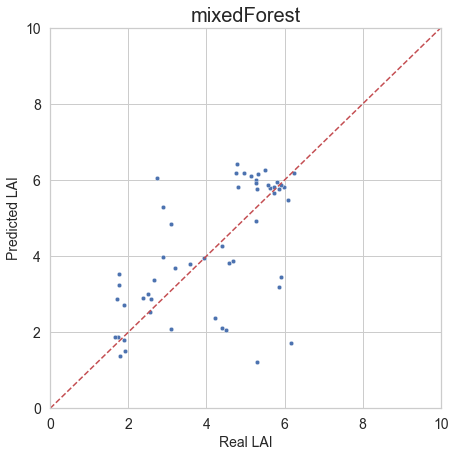

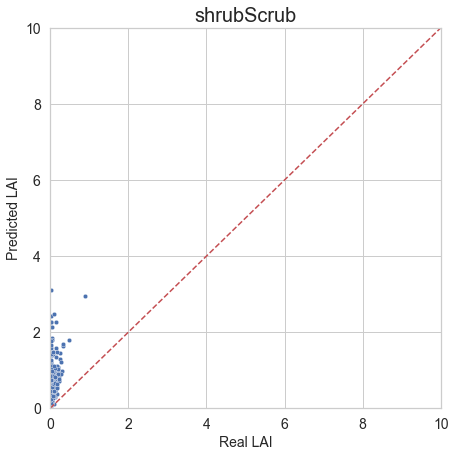

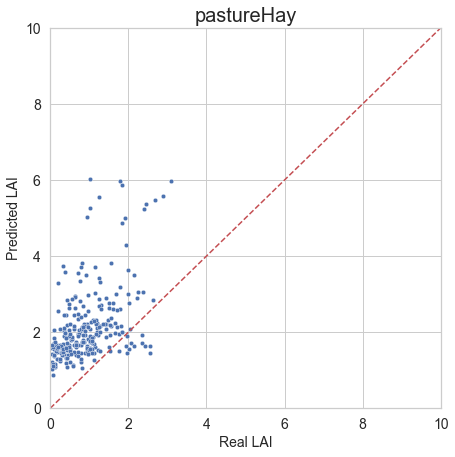

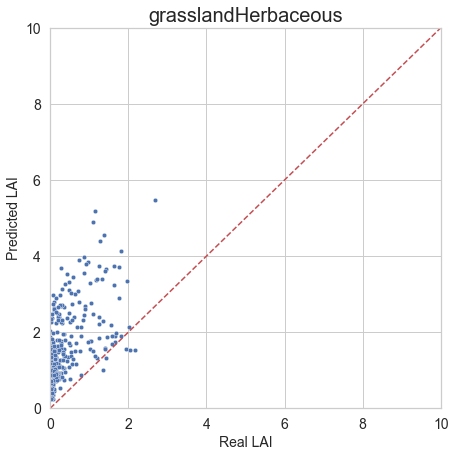

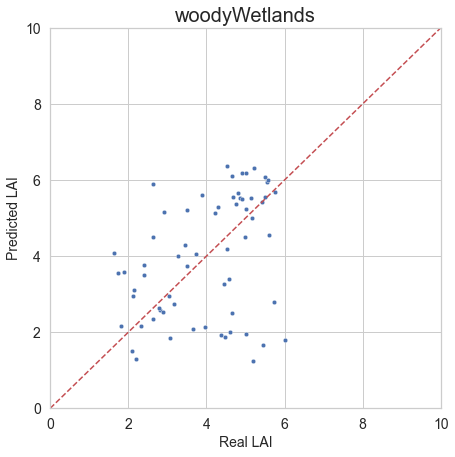

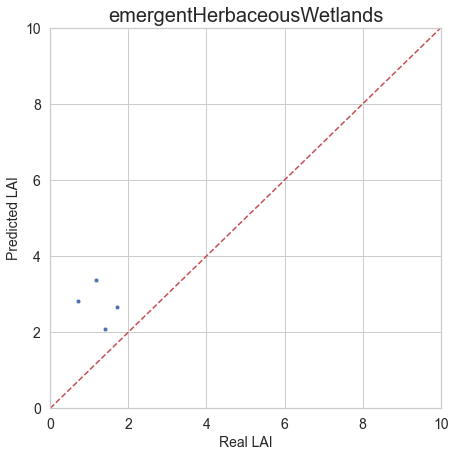

In [43]:
plot_error_scatter(temp, "lai", "predicted_lai", "nlcdClass", "Real LAI", "Predicted LAI", s=20)

In [83]:
linreg = LinearRegression
rf = RandomForestRegressor
hyperparams = {"n_estimators":10, "n_jobs":-1}
# scores = perform_simulation_cv(simulation_df, rf, hyperparams)

In [84]:
# perform_simulation_cv(simulation_df, rf, hyperparams, target_col="lai")

In [14]:
score, y_pred = get_validation_score(simulation_df, in_situ_df, rf, hyperparams, standardize=True)

NameError: name 'get_validation_score' is not defined

In [86]:
score

{'mean_absolute_error': 1.028402837816245,
 'mean_squared_error': 1.9188900196075505,
 'r2_score': 0.5240180945089661,
 'mean_absolute_percentage_error': 2204.0599634723126}

## GPR + AL

In [164]:
def GP_regression_std(regressor, X, batch_size):
    _, std = regressor.predict(X, return_std=True)
    # Perform argmax for batch_size samples
    query_idx = np.argpartition(std, -batch_size)[-batch_size:]
#     query_idx = np.argmax(std)
    return query_idx, X[query_idx]


In [222]:
def train_GPR_AL(X, y, n_initial=50, n_total=500, batch_size=50):
    n_batches = int((n_total - n_initial) / batch_size)
    n_last_batch = n_total - (n_initial + n_batches * batch_size)
    
    initial_idx = np.random.choice(range(len(X)), size=n_initial, replace=False)
    X_training, y_training = X[initial_idx], y[initial_idx]
    
    kernel = RBF(length_scale=1.9) \
                   + WhiteKernel()

    #              + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
#     kernel = RationalQuadratic(length_scale_bounds="fixed", alpha_bounds="fixed")

    regressor = ActiveLearner(
        estimator=GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10),
        query_strategy=GP_regression_std, 
        X_training=X_training, y_training=y_training
    )
    
    batches = [batch_size for i in range(n_batches)]
    
    if n_last_batch>0:
        batches.append(n_last_batch)
    
    for n_queries in tqdm(batches):
        query_idx, query_instance = regressor.query(X, batch_size)
        regressor.teach(X[query_idx], y[query_idx])
        
#         val_idx = [np.random.choice([i for i in range(0, len(y)) if i not in query_idx]) for j in range(0,50)]
        
    # This is of course cheating, validating on entire set!
    val_score = np.mean(np.square(y - regressor.predict(X)))
        print("Validation MSE: {}".format(val_score))
#     for i in tqdm(range(n_batches)):
#         query_idx, query_instance = regressor.query(X, batch_size)
#         regressor.teach(X[query_idx], y[query_idx])

#     if n_last_batch>0:
#         query_idx, query_instance = regressor.query(X, n_last_batch)
#         regressor.teach(X[query_idx], y[query_idx])
    
    return regressor

In [223]:
gpr_al = ActiveLearner
gpr_al_params = {"n_initial":100, "n_total":1000, "batch_size":100}

In [225]:
score, y_pred = get_validation_score(simulation_df, in_situ_df, gpr_al, gpr_al_params, standardize=True)

  0%|          | 0/9 [00:00<?, ?it/s]

Validation MSE: 3.6955268905423484
Validation MSE: 3.910256477173735
Validation MSE: 3.718216480137161
Validation MSE: 3.9280161083005076
Validation MSE: 3.890465291602412
Validation MSE: 3.5786764026948346
Validation MSE: 3.480688083269367
Validation MSE: 3.42465823069683
Validation MSE: 3.394456740809903


In [226]:
score

{'mean_absolute_error': 1.387689665759481,
 'mean_squared_error': 3.3777791688225984,
 'r2': 0.1621397012461825,
 'mean_absolute_percentage_error': 51.225291357867384}

In [212]:
y_temp = [temp_df["LAI_Miller"].mean()]*len(y_pred)
r2_score(temp_df["LAI_Miller"], y_temp)

NameError: name 'temp_df' is not defined

In [ ]:
score = get_validation_score(simulation_df, temp_df, gpr_al, gpr_al_params)
score

In [84]:
for nlcd in in_situ_df["nlcdClass"].unique():
    print(nlcd)
    display(in_situ_df[in_situ_df["nlcdClass"]==nlcd].describe())

deciduousForest


,LAI_Miller,LAI_Warren,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B10,B11,B12,QA10,QA20,QA60,cloud_probability
count,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.0,774.0,774.000000,774.000000
mean,4.887574,4.186781,0.032727,0.032515,0.049476,0.034321,0.083425,0.251557,0.307228,0.315593,0.333525,0.500372,25.878686,0.162878,0.078832,0.0,0.0,174.635659,9.201550
std,2.130407,1.654663,0.045107,0.040329,0.035816,0.039328,0.039214,0.082698,0.107070,0.107516,0.108637,0.220621,100.195228,0.045682,0.037279,0.0,0.0,548.132654,16.434454
min,0.125000,0.113000,-0.106119,-0.053657,-0.017403,-0.008774,0.008159,0.019741,0.024013,0.028198,0.028774,0.065384,-45.010871,0.022828,0.006513,0.0,0.0,0.000000,0.000000
25%,3.708250,3.377500,0.011615,0.013850,0.031658,0.013406,0.062236,0.189319,0.222452,0.237013,0.250836,0.362046,0.069451,0.140460,0.058307,0.0,0.0,0.000000,1.000000
50%,5.450000,4.688500,0.023907,0.023775,0.041686,0.022334,0.075823,0.263127,0.318230,0.327294,0.346805,0.484298,0.697486,0.159779,0.067429,0.0,0.0,0.000000,2.000000
75%,6.360000,5.280000,0.039480,0.037607,0.054139,0.040753,0.097091,0.311545,0.391319,0.399216,0.416452,0.600158,4.126531,0.186867,0.083258,0.0,0.0,0.000000,7.000000
max,10.980000,8.280000,0.314998,0.322431,0.313798,0.328378,0.352490,0.477446,0.574506,0.566069,0.612328,1.966341,954.630183,0.359214,0.278923,0.0,0.0,2048.000000,69.000000


cultivatedCrops


,LAI_Miller,LAI_Warren,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B10,B11,B12,QA10,QA20,QA60,cloud_probability
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.0,164.0,164.000000,164.000000
mean,0.505681,0.475605,0.089368,0.109323,0.138302,0.164032,0.196699,0.264022,0.291130,0.298217,0.316398,0.310474,1.051465,0.341075,0.276098,0.0,0.0,149.853659,4.573171
std,0.811635,0.741033,0.137652,0.131234,0.118524,0.124293,0.120439,0.111056,0.110051,0.106405,0.104480,0.150173,4.226537,0.095682,0.102494,0.0,0.0,534.966569,6.399828
min,0.002350,0.004200,0.003642,0.008713,0.018548,0.011670,0.030275,0.064861,0.073135,0.070538,0.075879,0.076207,-0.004594,0.050017,0.029134,0.0,0.0,0.000000,0.000000
25%,0.040175,0.054000,0.056843,0.070607,0.096524,0.108365,0.151961,0.210712,0.235867,0.244562,0.264584,0.211678,0.077003,0.285814,0.195077,0.0,0.0,0.000000,2.000000
50%,0.126000,0.133000,0.074232,0.093746,0.122242,0.158936,0.181729,0.250673,0.273236,0.284635,0.301966,0.278284,0.238723,0.366415,0.297753,0.0,0.0,0.000000,2.000000
75%,0.549250,0.458500,0.087074,0.115665,0.149105,0.193020,0.216983,0.288624,0.318692,0.333591,0.346313,0.368879,0.433781,0.413095,0.360488,0.0,0.0,0.000000,4.000000
max,4.110000,3.520000,1.119873,1.096225,1.013699,1.011749,1.043744,1.023045,0.994278,0.949065,0.952901,1.107989,43.650688,0.499321,0.462086,0.0,0.0,2048.000000,38.000000


evergreenForest


,LAI_Miller,LAI_Warren,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B10,B11,B12,QA10,QA20,QA60,cloud_probability
count,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.0,631.0,631.000000,631.000000
mean,2.557819,2.250309,0.038294,0.042907,0.059984,0.054207,0.097066,0.208057,0.240788,0.253026,0.267298,0.423072,47.781124,0.184994,0.102340,0.0,0.0,98.992076,10.232964
std,1.444094,1.241523,0.034049,0.038890,0.036713,0.042106,0.041486,0.059139,0.067929,0.070781,0.071921,0.205511,164.651151,0.073977,0.055676,0.0,0.0,406.137515,15.454324
min,0.269000,0.264000,-0.016751,-0.005190,-0.000234,-0.004446,0.011624,0.035172,0.043662,0.041215,0.047043,0.020227,-40.330787,0.026297,0.010238,0.0,0.0,0.000000,0.000000
25%,1.357000,1.181500,0.014634,0.019113,0.036768,0.026518,0.070488,0.170360,0.197191,0.212707,0.224026,0.307163,0.001635,0.134133,0.062144,0.0,0.0,0.000000,1.000000
50%,2.160000,1.990000,0.032588,0.034142,0.053208,0.042356,0.090276,0.212010,0.245609,0.256546,0.271358,0.402577,1.494772,0.168310,0.083066,0.0,0.0,0.000000,3.000000
75%,3.645000,3.240000,0.050648,0.054464,0.073484,0.070748,0.117255,0.238714,0.276929,0.290271,0.306521,0.496285,18.621612,0.226277,0.130247,0.0,0.0,0.000000,10.000000
max,6.290000,6.050000,0.278647,0.438084,0.397145,0.423431,0.415833,0.465605,0.481384,0.485907,0.517945,2.146761,1455.276090,0.392392,0.305618,0.0,0.0,2048.000000,68.000000


mixedForest


,LAI_Miller,LAI_Warren,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B10,B11,B12,QA10,QA20,QA60,cloud_probability
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.0,53.0,53.000000,53.000000
mean,4.593755,4.132887,0.029597,0.030208,0.045565,0.032877,0.080118,0.224832,0.264491,0.265182,0.285618,0.447256,2.798515,0.153287,0.077189,0.0,0.0,115.924528,6.150943
std,1.903193,1.547909,0.024995,0.022203,0.022754,0.026462,0.022420,0.066795,0.082877,0.084031,0.082148,0.155842,9.704467,0.028476,0.027287,0.0,0.0,477.788811,14.349211
min,1.450000,1.651000,-0.000033,0.005807,0.021081,0.008216,0.038286,0.090336,0.109574,0.116066,0.128733,0.183535,-21.888306,0.077251,0.033729,0.0,0.0,0.000000,0.000000
25%,2.823000,2.650000,0.014411,0.016469,0.032412,0.016015,0.066294,0.162882,0.179575,0.184112,0.201460,0.332432,0.069561,0.139686,0.058402,0.0,0.0,0.000000,0.000000
50%,5.120000,4.580000,0.023056,0.025198,0.040083,0.022077,0.074071,0.241289,0.276620,0.282676,0.297774,0.435585,0.576571,0.154542,0.068958,0.0,0.0,0.000000,1.000000
75%,6.310000,5.500000,0.032707,0.035624,0.051936,0.044052,0.084296,0.280358,0.328860,0.326517,0.346260,0.525689,1.582413,0.170377,0.087356,0.0,0.0,0.000000,2.000000
max,7.650000,6.230000,0.139448,0.132501,0.161645,0.159613,0.165027,0.347415,0.434867,0.429678,0.450376,0.916744,58.384495,0.208732,0.153058,0.0,0.0,2048.000000,63.000000


shrubScrub


,LAI_Miller,LAI_Warren,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B10,B11,B12,QA10,QA20,QA60,cloud_probability
count,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000,785.0,785.0,785.000000,785.000000
mean,0.036961,0.038703,0.082208,0.098640,0.131222,0.180878,0.209704,0.239773,0.255565,0.256330,0.275525,0.281441,0.607256,0.369836,0.320194,0.0,0.0,129.141401,4.472611
std,0.070423,0.060471,0.027083,0.023850,0.026458,0.041793,0.043225,0.045171,0.047117,0.047106,0.048862,0.088521,2.127154,0.066723,0.070073,0.0,0.0,494.072623,8.854094
min,0.000021,0.000030,0.011570,0.030863,0.046607,0.050926,0.059891,0.067934,0.074467,0.065564,0.077161,0.041145,-0.120226,0.081635,0.064120,0.0,0.0,0.000000,0.000000
25%,0.004900,0.007600,0.067319,0.084422,0.114493,0.153935,0.181928,0.211619,0.227426,0.229465,0.248238,0.224470,0.043408,0.335955,0.276443,0.0,0.0,0.000000,1.000000
50%,0.012200,0.017700,0.080442,0.097812,0.134274,0.181597,0.210989,0.243515,0.258001,0.260700,0.279982,0.268821,0.104510,0.378427,0.320151,0.0,0.0,0.000000,2.000000
75%,0.037600,0.045000,0.094487,0.111401,0.148504,0.209496,0.239215,0.272869,0.288975,0.289165,0.309397,0.334570,0.282038,0.411579,0.364513,0.0,0.0,0.000000,3.000000
max,1.130000,0.900000,0.468567,0.246217,0.217167,0.288064,0.325037,0.380460,0.409145,0.360491,0.386291,0.725537,28.738628,0.550109,0.492807,0.0,0.0,2048.000000,68.000000


pastureHay


,LAI_Miller,LAI_Warren,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B10,B11,B12,QA10,QA20,QA60,cloud_probability
count,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.0,259.0,259.000000,259.000000
mean,1.331695,0.949100,0.054908,0.059836,0.085645,0.078891,0.133249,0.290882,0.340131,0.352768,0.372546,0.578258,105.751844,0.279260,0.159533,0.0,0.0,126.517375,11.362934
std,1.034196,0.648525,0.022964,0.023434,0.024076,0.036481,0.037315,0.073193,0.094181,0.096649,0.097182,0.166705,260.301848,0.072639,0.055629,0.0,0.0,468.676541,13.414947
min,0.029000,0.044000,0.015584,0.015017,0.016885,0.010872,0.022671,0.060252,0.071385,0.070356,0.078171,0.071245,-22.281962,0.042042,0.017594,0.0,0.0,0.000000,1.000000
25%,0.510500,0.438000,0.039159,0.043369,0.069574,0.049067,0.107907,0.245411,0.282291,0.293793,0.315317,0.456272,3.751674,0.231883,0.116742,0.0,0.0,0.000000,3.000000
50%,1.110000,0.850000,0.050534,0.053028,0.081337,0.070373,0.128034,0.289394,0.331926,0.344612,0.367498,0.565561,10.420965,0.275822,0.147715,0.0,0.0,0.000000,6.000000
75%,1.775000,1.280000,0.064471,0.071450,0.099710,0.104247,0.155284,0.328134,0.384237,0.398412,0.416923,0.689712,29.003635,0.322571,0.199921,0.0,0.0,0.000000,13.000000
max,5.270000,3.090000,0.152733,0.152665,0.160456,0.192530,0.249087,0.506381,0.627145,0.636108,0.661600,0.946996,1277.589008,0.437273,0.297784,0.0,0.0,2048.000000,69.000000


grasslandHerbaceous


,LAI_Miller,LAI_Warren,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B10,B11,B12,QA10,QA20,QA60,cloud_probability
count,270.000000,2.700000e+02,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.0,270.0,270.000000,270.000000
mean,0.524636,4.494960e-01,0.082078,0.090361,0.111049,0.118206,0.159813,0.241873,0.268052,0.277799,0.292718,0.368537,1.744362,0.275827,0.181379,0.0,0.0,246.518519,8.029630
std,0.627950,5.283845e-01,0.105008,0.111343,0.106412,0.111124,0.094365,0.084513,0.084184,0.087808,0.079820,0.141832,4.955646,0.068340,0.058183,0.0,0.0,640.833053,14.617014
min,0.000027,3.000000e-07,-0.016742,-0.013292,0.003518,0.007270,0.035409,0.056801,0.061457,0.061821,0.065671,0.056595,-0.233767,0.056017,0.035584,0.0,0.0,0.000000,0.000000
25%,0.080200,8.575000e-02,0.036146,0.045065,0.070186,0.065873,0.120363,0.202940,0.223691,0.232492,0.246467,0.269145,0.091141,0.241176,0.133729,0.0,0.0,0.000000,1.000000
50%,0.242500,2.145000e-01,0.051793,0.067643,0.090151,0.097793,0.142490,0.228297,0.248670,0.260596,0.277244,0.342808,0.237207,0.290107,0.183838,0.0,0.0,0.000000,2.000000
75%,0.718250,6.050000e-01,0.075104,0.090387,0.112307,0.129891,0.164085,0.260963,0.295409,0.309494,0.329938,0.444553,1.190783,0.315419,0.233020,0.0,0.0,0.000000,6.000000
max,3.520000,2.680000e+00,0.736338,0.904209,0.903637,0.935347,0.863241,0.855375,0.800806,0.845635,0.688567,0.955193,38.780764,0.412199,0.347034,0.0,0.0,2048.000000,68.000000


woodyWetlands


,LAI_Miller,LAI_Warren,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B10,B11,B12,QA10,QA20,QA60,cloud_probability
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.0,64.0,64.000000,64.000000
mean,4.523219,3.990000,0.030243,0.031747,0.050077,0.032850,0.083749,0.217543,0.250286,0.267573,0.269839,0.414846,1.892536,0.145452,0.073085,0.0,0.0,192.000000,6.828125
std,1.688125,1.257612,0.027567,0.021562,0.018704,0.017346,0.018575,0.063125,0.075503,0.087421,0.078914,0.149328,4.869422,0.026202,0.018131,0.0,0.0,573.341307,14.760043
min,1.697000,1.640000,0.003854,0.008755,0.023498,0.011889,0.039853,0.099152,0.110673,0.108669,0.128627,0.157740,-6.589960,0.074337,0.033488,0.0,0.0,0.000000,0.000000
25%,3.116250,2.859500,0.014457,0.018691,0.036868,0.021757,0.071675,0.165133,0.191922,0.190615,0.199122,0.317487,0.130146,0.135117,0.061452,0.0,0.0,0.000000,1.000000
50%,4.810000,4.410000,0.022494,0.026374,0.048156,0.030198,0.081536,0.223106,0.260029,0.268447,0.281338,0.401207,0.690775,0.145554,0.070792,0.0,0.0,0.000000,2.000000
75%,6.032500,5.012500,0.032617,0.038367,0.060386,0.039214,0.093007,0.267644,0.309625,0.330017,0.330590,0.492876,1.559536,0.156167,0.079475,0.0,0.0,0.000000,3.250000
max,6.930000,6.000000,0.160326,0.128465,0.123049,0.106423,0.138260,0.393156,0.473398,0.471694,0.522783,0.855137,32.041023,0.250927,0.159443,0.0,0.0,2048.000000,66.000000


emergentHerbaceousWetlands


,LAI_Miller,LAI_Warren,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B10,B11,B12,QA10,QA20,QA60,cloud_probability
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.0,4.0,4.0,4.00000
mean,1.570000,1.252500,0.027581,0.033077,0.056030,0.048483,0.097778,0.235548,0.275148,0.301114,0.304862,0.330002,0.591336,0.182732,0.093033,0.0,0.0,0.0,1.50000
std,0.700238,0.424215,0.003922,0.006788,0.012966,0.015969,0.026744,0.045553,0.047149,0.057697,0.054582,0.052651,0.468406,0.057891,0.033992,0.0,0.0,0.0,0.57735
min,0.750000,0.710000,0.022754,0.026636,0.042143,0.031863,0.070522,0.190796,0.226430,0.245225,0.250019,0.288487,0.047097,0.129687,0.063841,0.0,0.0,0.0,1.00000
25%,1.305000,1.062500,0.025258,0.027838,0.050110,0.037531,0.083495,0.202243,0.240247,0.254447,0.267422,0.304186,0.319216,0.143840,0.067141,0.0,0.0,0.0,1.00000
50%,1.535000,1.290000,0.028126,0.032376,0.054302,0.047273,0.093363,0.230727,0.274094,0.302842,0.298470,0.312210,0.591336,0.170609,0.085899,0.0,0.0,0.0,1.50000
75%,1.800000,1.480000,0.030449,0.037616,0.060222,0.058225,0.107645,0.264032,0.308996,0.349509,0.335909,0.338025,0.863455,0.209501,0.111791,0.0,0.0,0.0,2.00000
max,2.460000,1.720000,0.031320,0.040920,0.073373,0.067523,0.133866,0.289943,0.325975,0.353549,0.372489,0.407100,1.135575,0.260023,0.136494,0.0,0.0,0.0,2.00000


## Experiment loop

## Save results

In [21]:
y_pred_1 = [2,5,6,1,4,6]
y_pred_2 = [3,1,4,1,2,1]
y_pred_3 = [3,1,4,1,2,1]
y_pred_n = [y_pred_1, y_pred_2, y_pred_3]

In [22]:
y_pred_all = np.array([y for y in y_pred_n])

In [23]:
y_pred_all.shape

(3, 6)

In [33]:
y_pred_all.T

array([[2, 3, 3],
       [5, 1, 1],
       [6, 4, 4],
       [1, 1, 1],
       [4, 2, 2],
       [6, 1, 1]])

In [30]:
X = [[5,4],
     [5,4],
     [5,4],
     [5,4],
     [5,4],
     [5,4],   
    ]

In [32]:
np.c_[X, y_pred_all.T]

array([[5, 4, 2, 3, 3],
       [5, 4, 5, 1, 1],
       [5, 4, 6, 4, 4],
       [5, 4, 1, 1, 1],
       [5, 4, 4, 2, 2],
       [5, 4, 6, 1, 1]])

In [35]:
3072*2

6144